# Character-based RNN Dinosaur name generator

![title](dinos.jpg)

As explained in : <hyper>https://www.tensorflow.org/tutorials/text/text_generation</hyper> for a different task.

### Process: <br>

1. Preprocessing
2. Model creation
3. Customized Training
4. Rewiring of model to generate text ( the prediction loop )

<br> The model can be seen below:

![image](model.jpg )

### 0. Loading of the dataset 

The dataset holds dinosaur names 

In [15]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import os
import time

import itertools
from itertools import chain

dinos = open('Dino.txt.txt', 'r').read()
dinos = dinos.lower().splitlines()
vocab = set(chain.from_iterable(dinos))

print('There are %d total Dinosaur names and %d unique characters in the data.' % (len(dinos), len(vocab)))
print(dinos[0:10])

There are 1536 total Dinosaur names and 26 unique characters in the data.
['aachenosaurus', 'aardonyx', 'abdallahsaurus', 'abelisaurus', 'abrictosaurus', 'abrosaurus', 'abydosaurus', 'acanthopholis', 'achelousaurus', 'acheroraptor']


### 1. Preprocessing
#### 1.1 Create lookup tables for characters to numbers and numbers to characters.  
This is going to help us transform the character inputs to numeric inputs so the model can understand them and the numeric results of the model to characters so we can understand the results

In [2]:
char2idx = { ch:i for i,ch in enumerate(sorted(vocab)) }
idx2char = { i:ch for i,ch in enumerate(sorted(vocab)) }
char2idx[" "] = 26
idx2char[26] = " "
print(char2idx)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26}


As you can see we add the 'space' character in the end of vocabulary. It will be needed and explained later

#### 1.2 Convert the dino names to numbers

In [3]:
text_as_int = [0]*len(dinos)
for i,dino in enumerate(dinos):
  text_as_int[i] = [char2idx[c] for c in dino ]
print ('{} ---- characters mapped to int ---- > {}'.format(repr(dinos[0]), text_as_int[0]))

'aachenosaurus' ---- characters mapped to int ---- > [0, 0, 2, 7, 4, 13, 14, 18, 0, 20, 17, 20, 18]


#### 1.3 Pad the input sequences in order to have the same length

Some dino names are really long and some others sort. We pad the dino names so all the names have the same length

In [4]:
print(len((max(dinos, key=len))))

26


The biggest name is of length 26. We decide all the names to have length 27 and we fill the rest of the numbers with the 'space' character.

In [5]:
from keras.preprocessing.sequence import pad_sequences

seq_length = 27

pad_dino_seq = pad_sequences(text_as_int, maxlen=seq_length, padding='post',value=26, truncating='post')
temp = str()
for i in pad_dino_seq[0]:
  temp = temp + idx2char[i]
print ('{} ---- integers with padding mapped to characters ---- > {}'.format(pad_dino_seq[0], temp))

Using TensorFlow backend.


[ 0  0  2  7  4 13 14 18  0 20 17 20 18 26 26 26 26 26 26 26 26 26 26 26
 26 26 26] ---- integers with padding mapped to characters ---- > aachenosaurus              


Keep in mind that after the name the 'space' character follows until the sequence of 27 characters is completed

#### 1.4 Create a Tensorflow dataset 

I concatenate all the numeric dinosaur sequences to one sequence and i create a Tf.Dataset by grouping them again in sequences of 27.

In [7]:
import tensorflow as tf

pad_dino_seq_com= list(itertools.chain(*pad_dino_seq))

sequences = tf.data.Dataset.from_tensor_slices(pad_dino_seq_com).batch(27, drop_remainder=True)

for one in sequences.take(1):
  print(one)

tf.Tensor(
[ 0  0  2  7  4 13 14 18  0 20 17 20 18 26 26 26 26 26 26 26 26 26 26 26
 26 26 26], shape=(27,), dtype=int32)


#### 1.5 Create groups of training examples and targets

What are the targets? Our model in every time step will learn to get a character and output the next most probable character. <br>
So, we need to shift every sequence by one character:

In [8]:
def split_input_target(chunk):
    
    input_text = chunk[:-1]
    target_text = chunk[1:]
    
    return input_text, target_text

dataset = sequences.map(split_input_target)

for input_example, target_example in  dataset.take(1):
  inp = str()
  tar = str()
  for i in input_example.numpy():
    inp = inp +idx2char[i]
  for i in target_example.numpy():
    tar = tar +idx2char[i]
  
  print ('Input data:', inp)
  print ('Target data:',tar)
  
for i, (input_idx, target_idx) in enumerate(zip(input_example.numpy()[:13], target_example.numpy()[:13])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Input data: aachenosaurus             
Target data: achenosaurus              
Step    0
  input: 0 ('a')
  expected output: 0 ('a')
Step    1
  input: 0 ('a')
  expected output: 2 ('c')
Step    2
  input: 2 ('c')
  expected output: 7 ('h')
Step    3
  input: 7 ('h')
  expected output: 4 ('e')
Step    4
  input: 4 ('e')
  expected output: 13 ('n')
Step    5
  input: 13 ('n')
  expected output: 14 ('o')
Step    6
  input: 14 ('o')
  expected output: 18 ('s')
Step    7
  input: 18 ('s')
  expected output: 0 ('a')
Step    8
  input: 0 ('a')
  expected output: 20 ('u')
Step    9
  input: 20 ('u')
  expected output: 17 ('r')
Step   10
  input: 17 ('r')
  expected output: 20 ('u')
Step   11
  input: 20 ('u')
  expected output: 18 ('s')
Step   12
  input: 18 ('s')
  expected output: 26 (' ')


#### 1.6 Now we can shuffle the data and create batches of names to be feeded  to the network

In [9]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset.take(1))

<TakeDataset shapes: ((16, 26), (16, 26)), types: (tf.int32, tf.int32)>


## 2. Model creation
#### 2.1 Define hyperparameters
The characters of the sequences will be emdedded before entering the Recurrent layer.<br>


In [10]:
vocab_size = len(vocab)

embedding_dim = 64

rnn_units = 256

In [11]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,GRU,Embedding,Input,Activation,Add,concatenate, RepeatVector

#### 2.2 Adding the layers into the model

In [35]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [36]:
model = build_model(
  vocab_size = vocab_size+1,
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (16, None, 64)            1728      
_________________________________________________________________
gru_1 (GRU)                  (16, None, 256)           247296    
_________________________________________________________________
dense_1 (Dense)              (16, None, 27)            6939      
Total params: 255,963
Trainable params: 255,963
Non-trainable params: 0
_________________________________________________________________


#### 2.3 Defining loss function and optimizer

In [37]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [38]:
model.compile(optimizer=optimizer, loss=loss)

## 3. Customized Training

First, saving checkpoint files of the model every x number of epochs ( defined in training ) <br>
We will need this after the training for in order to create the generator model

In [39]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints/3'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### 3.1 Defining the training step. 
I use the tf.GradientTape function to track the gradients in each forward pass in the "grads" step.

In [40]:
@tf.function
def train_step(inp, target):
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

#### 3.2 Simulating the training phase

For each epoch stated in the beginning, for each batch the training step function is called.<br>
There the model makes a prediction and a loss is calculated and the weights of the model are updated accordingly.<br>
I keep the loss in a list to plot the loss function over time later.

In [41]:
# Training step
EPOCHS = 10
history = list()
for epoch in range(EPOCHS):
  start = time.time()

  # initializing the hidden state at the start of every epoch
  # initally hidden is None
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target)
    
    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    history.append(loss.numpy())
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 3.2942323684692383
Epoch 1 Loss 1.1465
Time taken for 1 epoch 1.6161861419677734 sec

Epoch 2 Batch 0 Loss 1.548633098602295
Epoch 2 Loss 1.0168
Time taken for 1 epoch 0.34108567237854004 sec

Epoch 3 Batch 0 Loss 1.1183886528015137
Epoch 3 Loss 0.7858
Time taken for 1 epoch 0.3344557285308838 sec

Epoch 4 Batch 0 Loss 0.8576366901397705
Epoch 4 Loss 0.7706
Time taken for 1 epoch 0.32712578773498535 sec

Epoch 5 Batch 0 Loss 0.7919222712516785
Epoch 5 Loss 0.8125
Time taken for 1 epoch 0.39356112480163574 sec

Epoch 6 Batch 0 Loss 0.8132436275482178
Epoch 6 Loss 0.9134
Time taken for 1 epoch 0.32482314109802246 sec

Epoch 7 Batch 0 Loss 0.8476177453994751
Epoch 7 Loss 0.8335
Time taken for 1 epoch 0.32413244247436523 sec

Epoch 8 Batch 0 Loss 0.8000958561897278
Epoch 8 Loss 0.8394
Time taken for 1 epoch 0.3198111057281494 sec

Epoch 9 Batch 0 Loss 0.8080747127532959
Epoch 9 Loss 0.6838
Time taken for 1 epoch 0.32413339614868164 sec

Epoch 10 Batch 0 Loss 0.83361953

#### 3.3 Plot the loss over time

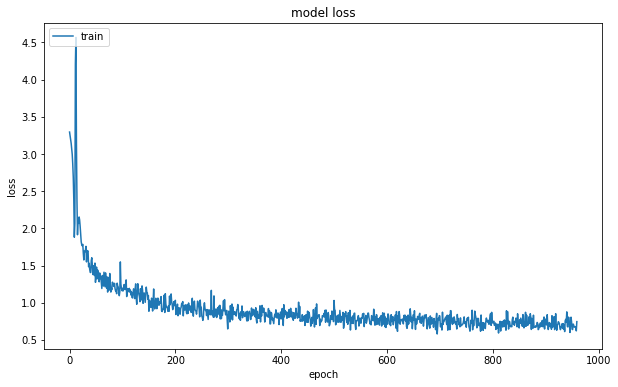

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 4. Rewiring the model

This phase is crucial to test the model. <br>
In the training phase the input in every time step was a single character and the output was a single character.<br> The output was compared with the desired output and a loss was calculated. <br>On the next timestep, the second input was introduced to the model and the same process was ongoing until the end of each sequence.

##### Now we want to feed the model its own output of the previous timestep so it can generate a name on its own as shown in the picture below:

![title](rewiring.jpg)

#### 4.1 Change the batch size
Initially we want to change the model`s batch size to 1 so we wont have to feed it with BATCH_SIZE number of sequences to test it. <br>
We do that by creating a different model with batch size 1 and loading the weights of the last iteration of the training.


In [46]:
model = build_model(vocab_size+1, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 64)             1728      
_________________________________________________________________
gru_2 (GRU)                  (1, None, 256)            247296    
_________________________________________________________________
dense_2 (Dense)              (1, None, 27)             6939      
Total params: 255,963
Trainable params: 255,963
Non-trainable params: 0
_________________________________________________________________


#### 4.1 Create the function to generate names



In [81]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 100

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [97]:
print(generate_text(model, start_string=u"vel"))

velusaurus                                                                                             


# Thank you!